In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from sklearn.metrics import r2_score
from truesight.utils import generate_syntetic_data

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
df = pd.read_csv('datasets\Stock Market\stock_market.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [3]:
season_length = 365
forecast_horizon = 180

In [4]:
from statsforecast.models import SeasonalNaive
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, alias="LinearRegression"),
    ModelWrapper(DecisionTreeRegressor, horizon=forecast_horizon, alias="DecisionTreeRegressor"),
    #ModelWrapper(LGBMRegressor, horizon=forecast_horizon, alias="LGBMRegressor"),
    ModelWrapper(XGBRegressor, horizon=forecast_horizon, alias="XGBRegressor")
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = forecast_horizon, 
    season_length = season_length,
    date_freq = "D", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

100%|██████████| 692/692 [00:30<00:00, 22.72it/s]


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 4, verbose = False),
]

if True:
    models_nocov = models[-1:]
    X_train_nocov = X_train[-1:]
    X_val_nocov = X_val[-1:]

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    ts_nocov = TrueSight(models_nocov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_nocov.compile(optimizer=optimizer, loss='mse')

    ts_nocov.fit(
        x = X_train_nocov, y = Y_train,
        validation_data = [X_val_nocov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_nocov.plot_training_history()
    ts_nocov.save_weights('nocov.h5')

    models_wcov = models.copy()
    X_train_wcov = X_train.copy()
    X_val_wcov = X_val.copy()

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    ts_wcov= TrueSight(models_wcov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_wcov.compile(optimizer=optimizer, loss='mse')

    ts_wcov.fit(
        x = X_train_wcov, y = Y_train,
        validation_data = [X_val_wcov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_wcov.plot_training_history()
    ts_wcov.save_weights('ts_wcov.h5')

    yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
    yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)
else:
    yhat_nocov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_nocov.npy')
    yhat_wcov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_wcov.npy')

In [23]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.177842
mape        0.088953
mse      1620.187014
rmse       40.251547
mae        11.966052
dtype: float64

In [24]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape       0.255635
mape        0.127858
mse      2211.312203
rmse       47.024591
mae        16.747834
dtype: float64

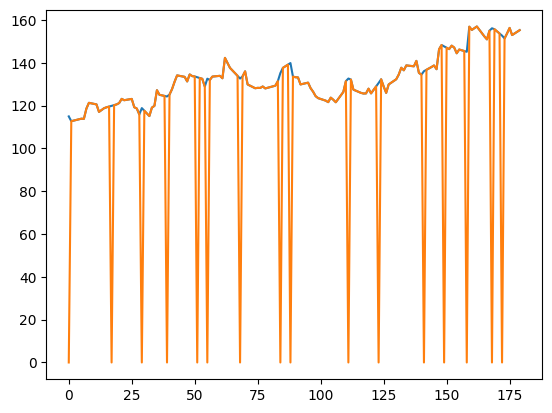

In [26]:
from matplotlib import pyplot as plt
idx = np.random.randint(0, len(ids_val))
plt.plot(Y_val[idx])
plt.plot(yhat_wcov.mean(axis = 0)[idx])

In [12]:
r2_score(Y_val, yhat_wcov.mean(axis=0))

-2.7207257207249102e+29

In [13]:
r2_score(Y_val, yhat_nocov.mean(axis=0))

-1.2459172776961413e+30

In [14]:
group_a = r2_score(Y_val.T, yhat_wcov.mean(axis=0).T, multioutput='raw_values')
group_b = r2_score(Y_val.T, yhat_nocov.mean(axis=0).T, multioutput='raw_values')

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 83064520.1159155
P-Value: 0.0


In [15]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -51510.509515242025
P-Value: 0.0


In [16]:
group_a = mape(Y_val, yhat_wcov.mean(axis=0))
group_b = mape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -25761.39567900294
P-Value: 0.0


In [17]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -83064520.12087308
P-Value: 0.0


In [18]:
group_a = rmse(Y_val, yhat_wcov.mean(axis=0))
group_b = rmse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -84234943.8792679
P-Value: 0.0


In [19]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -23836.21919052782
P-Value: 0.0
